# Group 7 - Real-Time Train Crowding Forecasting 
## Marc Ebersberger, Daniel Harnden, Cristina Radian, Shelby Smith 

The goal of this project is to give SNCF-Transilien, a French transit company, the tools to predict the train occupancy rate of a given train at a given station. Occupancy is referred to as the “crowding factor” (the total number of passengers on-board divided by the total capacity of the train), and data was collected by SCNF-Transilien regarding the crowding factor of the same train at previous stations and previous trains at the same station.

The given data is split into 12 variables; 6 contextual variables and 6 lag variables.

### Contextual Variables

* d - Date: The date the data was collected in YYYYMMDD format.
* p - Train: An ID (unique by day d) between 1 and 55 (inclusive).
* q - Station: The ID of the station where the data was collected.
* h - Hour: The hour the data was collected in HH:00:00, 24 hour time format.
* w - Way: Whether the train is heading towards Paris (0) or away from Paris (1).
* c - Composition: The number of train units, 1 or 2.

### Lag Variables

The six lag variables represent the "Crowding Factor" (CF) of the train and follow the naming scheme of pXqY, where p stands for the train and q stands for the station. CF is stored as a floating point number between 0 and 1 in the form of 0.XYZ. p0q0 is the CF of the current train at the current station, p3q0 is the CF of the third previous train at the current station, and p0q3 is the CF of the current train at the third previous station.

* p1q0 ∈ [0,1]: The CF of the previous train p-1 at the same station q.
* p2q0 ∈ [0,1]: The CF of the previous train p-2 at the same station q.
* p3q0 ∈ [0,1]: The CF of the previous train p-3 at the same station q.
* p0q1 ∈ [0,1]: The CF of the same train p at the previous station q-1.
* p0q2 ∈ [0,1]: The CF of the same train p at the previous station q-2.
* p0q3 ∈ [0,1]: The CF of the same train p at the previous station q-3.

### **Note: It is possible for the lag variables to be NA, meaning that there is no CF data for that particular dates, hour, and train.**

# Importing Packages and Verifying Data

In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path as path
import matplotlib.pyplot as plt
import numpy as np
import math
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

Xtrain = pd.read_csv(path('data/Xtrain.csv'))
Ytrain = pd.read_csv(path('data/Ytrain.csv'))
Xtest = pd.read_csv(path('data/Xtest.csv'))
Ysample = pd.read_csv(path('data/Ysample.csv'))

print('X Training Set', Xtrain.shape)
print('Y Training Set', Ytrain.shape)
print('X Testing Set ', Xtest.shape)
print('Y Sample Set  ', Ysample.shape)

X Training Set (31119, 12)
Y Training Set (31119, 2)
X Testing Set  (13752, 12)
Y Sample Set   (13752, 2)


## Combining Xtrain and Ytrain into TrainData

In [2]:
Ytrain = Ytrain.loc[:, ~Ytrain.columns.str.contains('^Unnamed')]
TrainData = Xtrain
TrainData = TrainData.merge(Ytrain, left_index= True, right_index= True)

TrainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
 12  p0q0         31119 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 3.1+ MB


In [3]:
TrainData.head()

,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091,0.216
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106,0.216
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111,0.227
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108,0.229
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096,0.225


# Cursory Data Analysis

## Missing Values

### There are four types of missing values:

* 1) Rows that contain no usable data in all rows

* 2) Rows that are missing data in the *hour* column

* 3) Rows that are missing data in the *pXq0*

* 4) Rows that are missing data in the *p0qX*

In [4]:
TrainData.isna().sum()

date              0
train             0
way               0
station           0
hour           3204
composition       0
p1q0           2052
p2q0           4145
p3q0           6184
p0q1           3202
p0q2           6399
p0q3           9592
p0q0              0
dtype: int64

### There are 4 train stations that contain missing values in all p & q data:

In [5]:
temp = TrainData[TrainData['p1q0'].isna() & TrainData['p2q0'].isna() & TrainData['p3q0'].isna() & TrainData['p0q1'].isna() & TrainData['p0q2'].isna() & TrainData['p0q3'].isna()]
print(temp['station'].unique())

['AX' 'BG' 'AZ' 'AR']


### Stations AR and AX have some data in the *pXq0* columns, but contain no hour data

### Station AR:

In [6]:
temp = TrainData.loc[TrainData['station']=='AR']
print("List of unique hours: ", temp['hour'].unique())
temp

List of unique hours:  [nan]


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
21414,2019-01-07,45,0,AR,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.021
21415,2019-01-08,45,0,AR,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.020
21416,2019-01-10,45,0,AR,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.017
21417,2019-01-11,45,0,AR,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.022
21418,2019-01-14,45,0,AR,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25522,2019-05-13,50,0,AR,NaN,2,0.04400,0.0410,0.0290,NaN,NaN,NaN,0.021
25523,2019-05-14,50,0,AR,NaN,2,0.04000,0.0480,0.0300,NaN,NaN,NaN,0.014
25524,2019-05-20,50,0,AR,NaN,2,0.04100,0.0460,0.0240,NaN,NaN,NaN,0.022
25525,2019-03-21,50,0,AR,NaN,2,0.04300,0.0450,0.0260,NaN,NaN,NaN,0.024


### Station AX:

In [7]:
temp = TrainData.loc[TrainData['station']=='AX']
print("List of unique hours: ", temp['hour'].unique())
temp

List of unique hours:  [nan]


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
406,2019-01-07,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.045
407,2019-01-08,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.044
408,2019-01-10,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.061
409,2019-01-11,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.042
410,2019-01-14,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30938,2019-05-13,9,0,AX,NaN,2,0.0840,0.110822,0.0970,NaN,NaN,NaN,0.080
30939,2019-05-14,9,0,AX,NaN,2,0.0940,0.100000,0.1190,NaN,NaN,NaN,0.089
30940,2019-05-15,9,0,AX,NaN,2,0.0910,0.085000,0.1060,NaN,NaN,NaN,0.099
30941,2019-03-21,9,0,AX,NaN,2,0.1070,0.107000,0.0950,NaN,NaN,NaN,0.074


### Stations AZ and BG have a mix of rows that contain useful information and rows that contain no p & q data

### Station AZ: 

In [8]:
temp = TrainData.loc[TrainData['station']=='AZ']
print("List of unique hours: ", temp['hour'].unique())
temp = temp[temp['hour'].isna() == False]
temp

List of unique hours:  [nan '06:00:00' '07:00:00' '08:00:00' '09:00:00']


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
21532,2019-01-07,45,0,AZ,06:00:00,2,0.048,NaN,NaN,0.075,0.131,0.186,0.225
21533,2019-01-08,45,0,AZ,06:00:00,2,0.068,NaN,NaN,0.084,0.140,0.185,0.219
21534,2019-01-10,45,0,AZ,06:00:00,2,0.061,NaN,NaN,0.088,0.136,0.183,0.221
21535,2019-01-11,45,0,AZ,06:00:00,2,0.049,NaN,NaN,0.098,0.151,0.197,0.223
21536,2019-01-14,45,0,AZ,06:00:00,2,0.061,NaN,NaN,0.102,0.158,0.211,0.253
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28534,2019-05-16,55,0,AZ,09:00:00,2,0.159,0.5870,0.37476,0.205,0.256,0.294,0.397
28535,2019-05-20,55,0,AZ,09:00:00,2,0.126,0.0990,0.40200,0.234,0.294,0.330,0.357
28536,2019-04-17,55,0,AZ,09:00:00,2,0.102,0.1036,0.35170,0.184,0.226,0.270,0.316
28537,2019-03-21,55,0,AZ,09:00:00,2,0.144,0.0670,0.42600,0.215,0.265,0.315,0.355


### Station BG:

In [9]:
temp = TrainData.loc[TrainData['station']=='BG']
print("List of unique hours: ", temp['hour'].unique())
temp = temp[temp['hour'].isna() == False]
temp

List of unique hours:  [nan '06:00:00' '07:00:00' '08:00:00']


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
13236,2019-01-07,29,0,BG,06:00:00,2,0.01500,NaN,NaN,NaN,NaN,NaN,0.068
13237,2019-01-08,29,0,BG,06:00:00,2,0.01700,NaN,NaN,NaN,NaN,NaN,0.053
13238,2019-01-09,29,0,BG,06:00:00,2,0.01665,NaN,NaN,NaN,NaN,NaN,0.052
13239,2019-01-10,29,0,BG,06:00:00,2,0.01000,NaN,NaN,NaN,NaN,NaN,0.059
13240,2019-01-11,29,0,BG,06:00:00,2,0.01665,NaN,NaN,NaN,NaN,NaN,0.040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17082,2019-05-09,33,0,BG,08:00:00,2,0.04780,0.0510,0.147,NaN,NaN,NaN,0.081
17083,2019-05-10,33,0,BG,08:00:00,2,0.05300,0.0500,0.121,NaN,NaN,NaN,0.088
17084,2019-05-15,33,0,BG,08:00:00,2,0.03400,0.0497,0.126,NaN,NaN,NaN,0.083
17085,2019-05-20,33,0,BG,08:00:00,2,0.05900,0.0540,0.146,NaN,NaN,NaN,0.089


## Redundant Values

### There are two types of redundant values:

* 1) The "Way" variable

* 2) The "Composition" variable

### Way:

In [10]:
numToParis = 0
numFromParis = 0

for i in TrainData["way"]:
    if i == 0:
        numToParis += 1
    else:
        numFromParis += 1

print("Number of trains to Paris:   " + str(numToParis))
print("Number of trains from Paris: " + str(numFromParis))
print("% of trains with going to Paris: " + str(round((numToParis / (numToParis + numFromParis)), 4) * 100))

Number of trains to Paris:   31119
Number of trains from Paris: 0
% of trains with going to Paris: 100.0


### Composition:

In [11]:
numOfCompOne = 0
numOfCompTwo = 0

for i in TrainData["composition"]:
    if i == 1:
        numOfCompOne += 1
    else:
        numOfCompTwo += 1

print("Number of trains with one train unit:  " + str(numOfCompOne))
print("Number of trains with two train units: " + str(numOfCompTwo))
print("% of trains with one train unit: " + str(round((numOfCompOne / (numOfCompOne + numOfCompTwo)), 4) * 100))

Number of trains with one train unit:  11
Number of trains with two train units: 31108
% of trains with one train unit: 0.04


## Analyzing Remaining Data

### Finding Relationships Between Train and Station (Train Lines)

<AxesSubplot:xlabel='train', ylabel='station'>

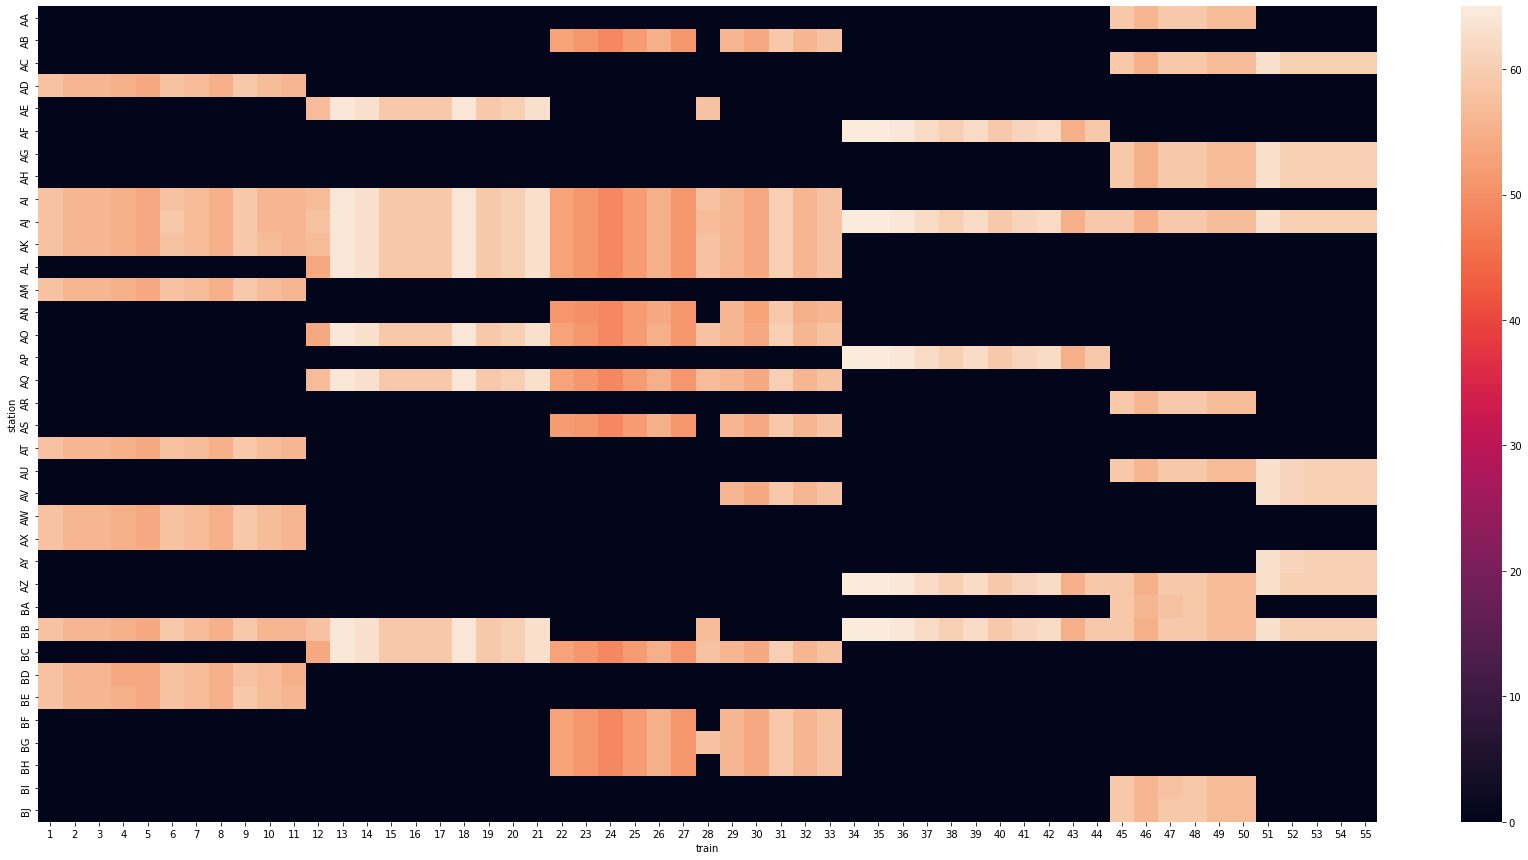

In [12]:
plt.rcParams['figure.figsize'] = [30, 15]

sns.heatmap(TrainData.groupby(['station','train']).size().unstack(fill_value=0))

# Data Cleaning

## Due to the way SNCF-Transilien is conducting the competition, we are unable to remove or add any rows to the data. However, we are able to remove and add columns.

* 1) We add the lines determined by analyzing the relationship between the train and station variables.
* 2) We replace the PQ variables that are NA with the mean of their respective column.
* 3) We take the information stored in date (stored in the YYYY/MM/DD format) and create the weekday and month columns.
* 4) We drop hour, way, and composition.

In [13]:
def cleaning(dirty_df):
    # Add lines
    line = []
    for i in dirty_df["train"]:
        if i <= 11:
            line.append(0)
        elif i <= 21:
            line.append(1)
        elif i <= 27:
            line.append(2)
        elif i == 28:
            line.append(3)
        elif i <= 33:
            line.append(4)
        elif i <= 44:
            line.append(5)
        elif i <= 50:
            line.append(6)
        else:
            line.append(7)
    dirty_df.insert(1,'line',line)
    
    # Store the means
    p1q0Mean = dirty_df['p1q0'].mean()
    p2q0Mean = dirty_df['p2q0'].mean()
    p3q0Mean = dirty_df['p3q0'].mean()
    p0q1Mean = dirty_df['p0q1'].mean()
    p0q2Mean = dirty_df['p0q2'].mean()
    p0q3Mean = dirty_df['p0q3'].mean()
    
    # Replace nulls in p*q0
    for i, row in dirty_df.iterrows():
        if math.isnan(row['p1q0']) and math.isnan(row['p2q0']) and math.isnan(row['p2q0']):
            dirty_df.at[i, 'p1q0'] = (p1q0Mean + random.uniform(-0.01, 0.02))
            dirty_df.at[i, 'p2q0'] = (p2q0Mean + random.uniform(-0.01, 0.02))
            dirty_df.at[i, 'p3q0'] = (p3q0Mean + random.uniform(-0.01, 0.02))
        elif math.isnan(row['p2q0']) and math.isnan(row['p3q0']):
            dirty_df.at[i, 'p2q0'] = (dirty_df['p2q0'].mean() + random.uniform(-0.01, 0.02))
            dirty_df.at[i, 'p3q0'] = (p3q0Mean + random.uniform(-0.01, 0.02))
        elif math.isnan(row['p3q0']):
            dirty_df.at[i,'p3q0'] = (p3q0Mean + random.uniform(-0.01, 0.02))
            
    # Replace nulls in p0q*
    for i, row in dirty_df.iterrows():
        if math.isnan(row['p0q1']) and math.isnan(row['p0q2']) and math.isnan(row['p0q3']):
            dirty_df.at[i, 'p0q1'] = (p0q1Mean + random.uniform(-0.01, 0.02))
            dirty_df.at[i, 'p0q2'] = (p0q2Mean + random.uniform(-0.01, 0.02))
            dirty_df.at[i, 'p0q3'] = (p0q3Mean + random.uniform(-0.01, 0.02))
        elif math.isnan(row['p0q2']) and math.isnan(row['p0q3']):
            dirty_df.at[i, 'p0q2'] = (p0q2Mean + random.uniform(-0.01, 0.02))
            dirty_df.at[i, 'p0q3'] = (p0q3Mean + random.uniform(-0.01, 0.02))
        elif math.isnan(row['p0q3']):
            dirty_df.at[i,'p0q3'] = (p0q3Mean + random.uniform(-0.01, 0.02))
                  
    # Add month, day, and weekday
    dirty_df['date'] = pd.to_datetime(dirty_df['date'], format='%Y/%m/%d')
    weekday = dirty_df['date'].dt.weekday
    dirty_df.insert(1,'weekday',weekday)
    month = dirty_df['date'].dt.month
    dirty_df.insert(2,'month',month)
    dirty_df = dirty_df.drop('date', axis=1)
    
    # Drop hour, way, and compoisition
    dirty_df = dirty_df.drop('hour', axis=1)
    dirty_df = dirty_df.drop('way', axis=1)
    dirty_df = dirty_df.drop('composition', axis=1)

    return dirty_df

In [14]:
TrainData = cleaning(TrainData)
TrainData

,weekday,month,line,train,station,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
0,0,1,0,1,AD,0.246914,0.260630,0.322580,0.201,0.138,0.091000,0.216
1,1,1,0,1,AD,0.240698,0.270717,0.319842,0.204,0.152,0.106000,0.216
2,3,1,0,1,AD,0.237548,0.265235,0.318250,0.213,0.153,0.111000,0.227
3,4,1,0,1,AD,0.226559,0.241835,0.310470,0.213,0.152,0.108000,0.229
4,0,1,0,1,AD,0.236158,0.270773,0.325069,0.210,0.147,0.096000,0.225
...,...,...,...,...,...,...,...,...,...,...,...,...
31114,0,5,0,9,BE,0.152000,0.188600,0.157000,0.080,0.100,0.201415,0.111
31115,1,5,0,9,BE,0.153000,0.180400,0.191000,0.089,0.121,0.217145,0.143
31116,2,5,0,9,BE,0.166000,0.149000,0.168000,0.099,0.129,0.221044,0.139
31117,3,3,0,9,BE,0.182000,0.193000,0.162000,0.074,0.101,0.225734,0.117


# Cleaned Data Analysis

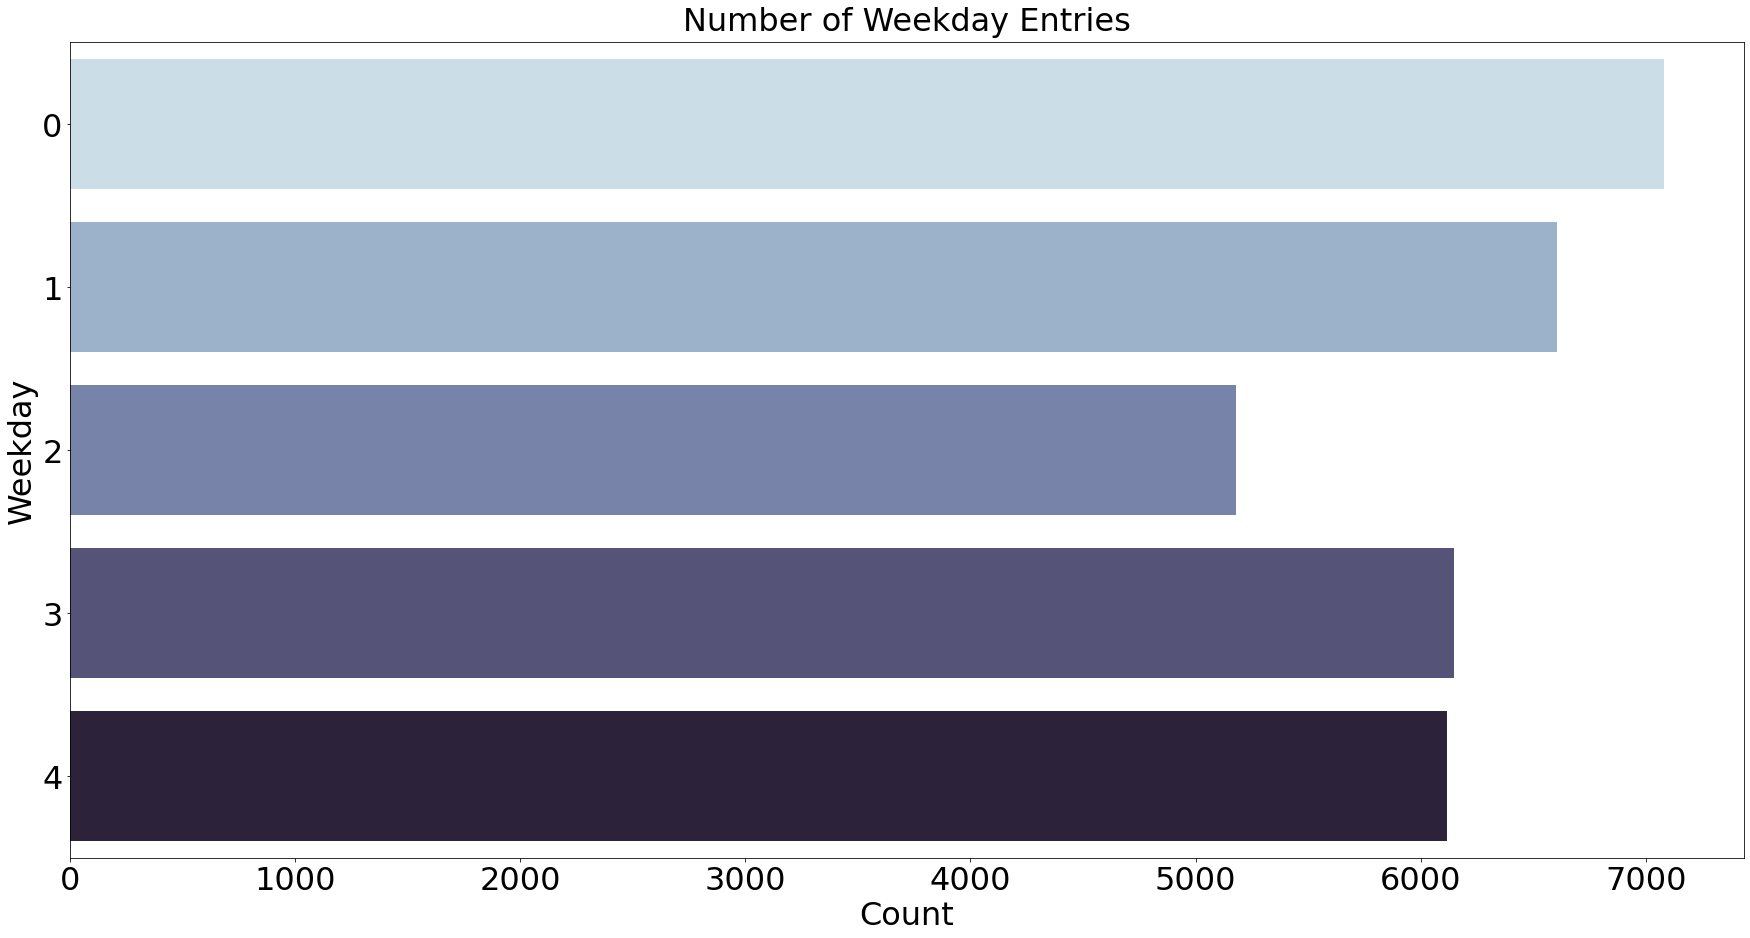

weekday
0    7079
1    6603
2    5178
3    6145
4    6114
dtype: int64

In [15]:
sns.countplot(y=TrainData['weekday'], palette='ch:s=.25,rot=-.25').set_title('Number of Weekday Entries', fontdict={'fontsize':32}, pad=12)

plt.xticks(size=32)
plt.yticks(size=32)

plt.xlabel('Count', fontsize=32)
plt.ylabel('Weekday', fontsize=32)

plt.show()

TrainData.groupby('weekday').size()

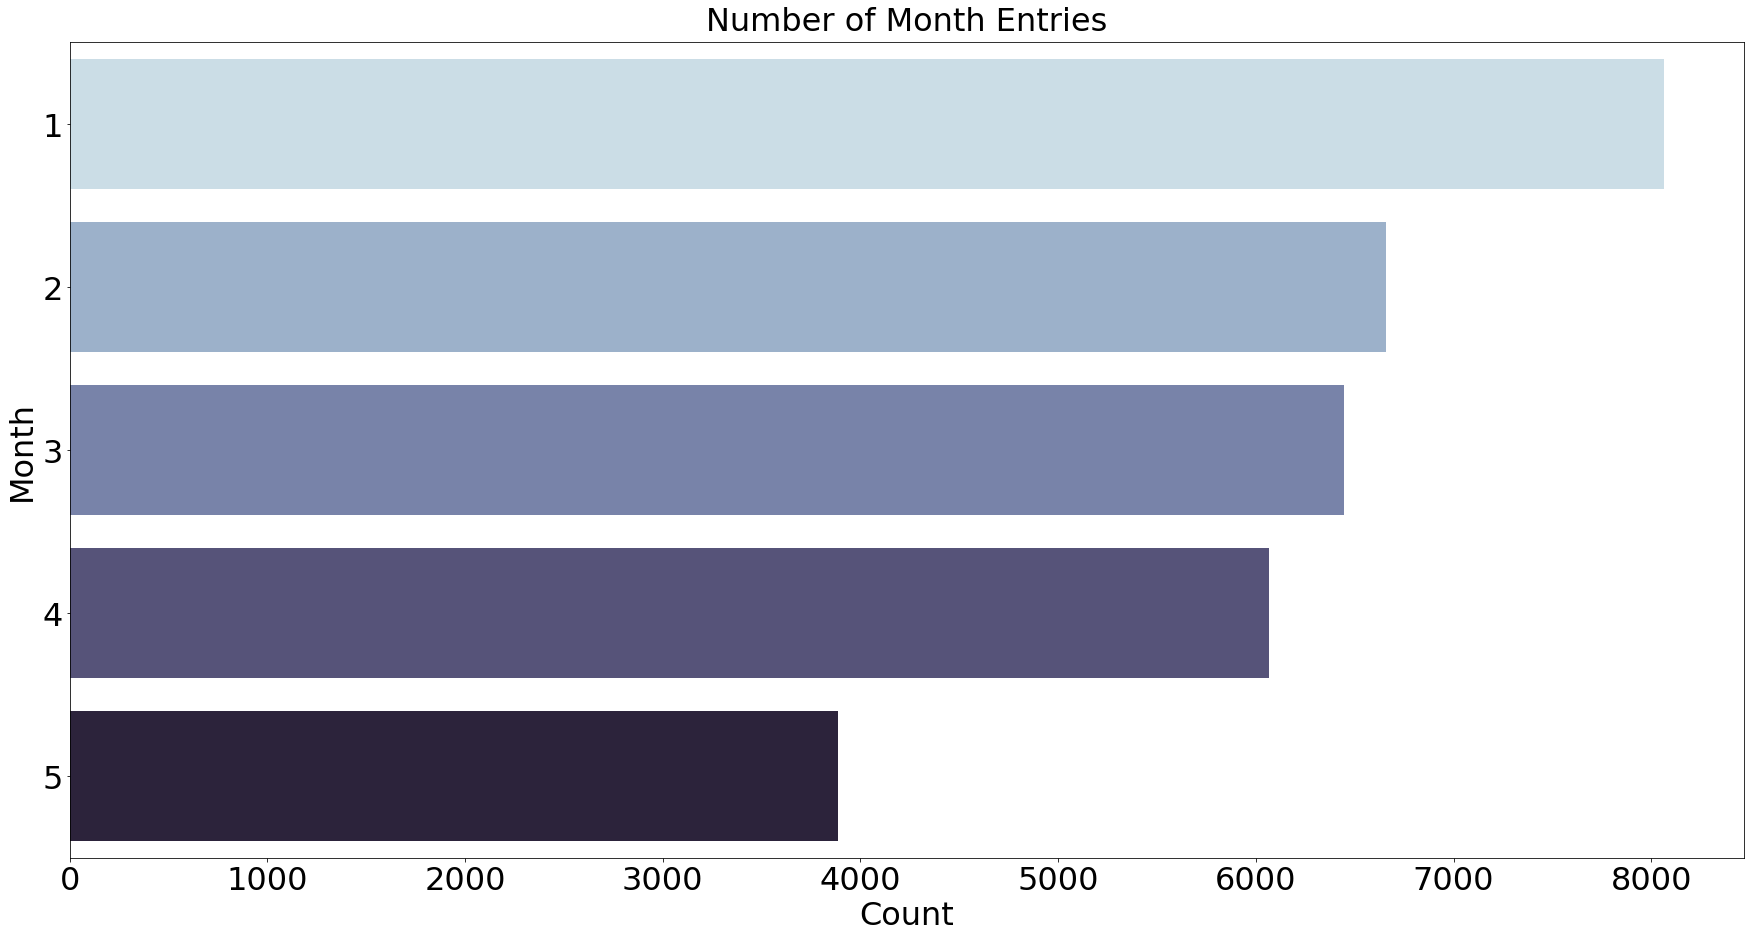

month
1    8064
2    6657
3    6444
4    6066
5    3888
dtype: int64

In [16]:
sns.countplot(y=TrainData['month'], palette='ch:s=.25,rot=-.25').set_title('Number of Month Entries', fontdict={'fontsize':32}, pad=12)

plt.xticks(size=32)
plt.yticks(size=32)

plt.xlabel('Count', fontsize=32)
plt.ylabel('Month', fontsize=32)

plt.show()

TrainData.groupby('month').size()

Text(0.5, 1.0, 'All q Variables')

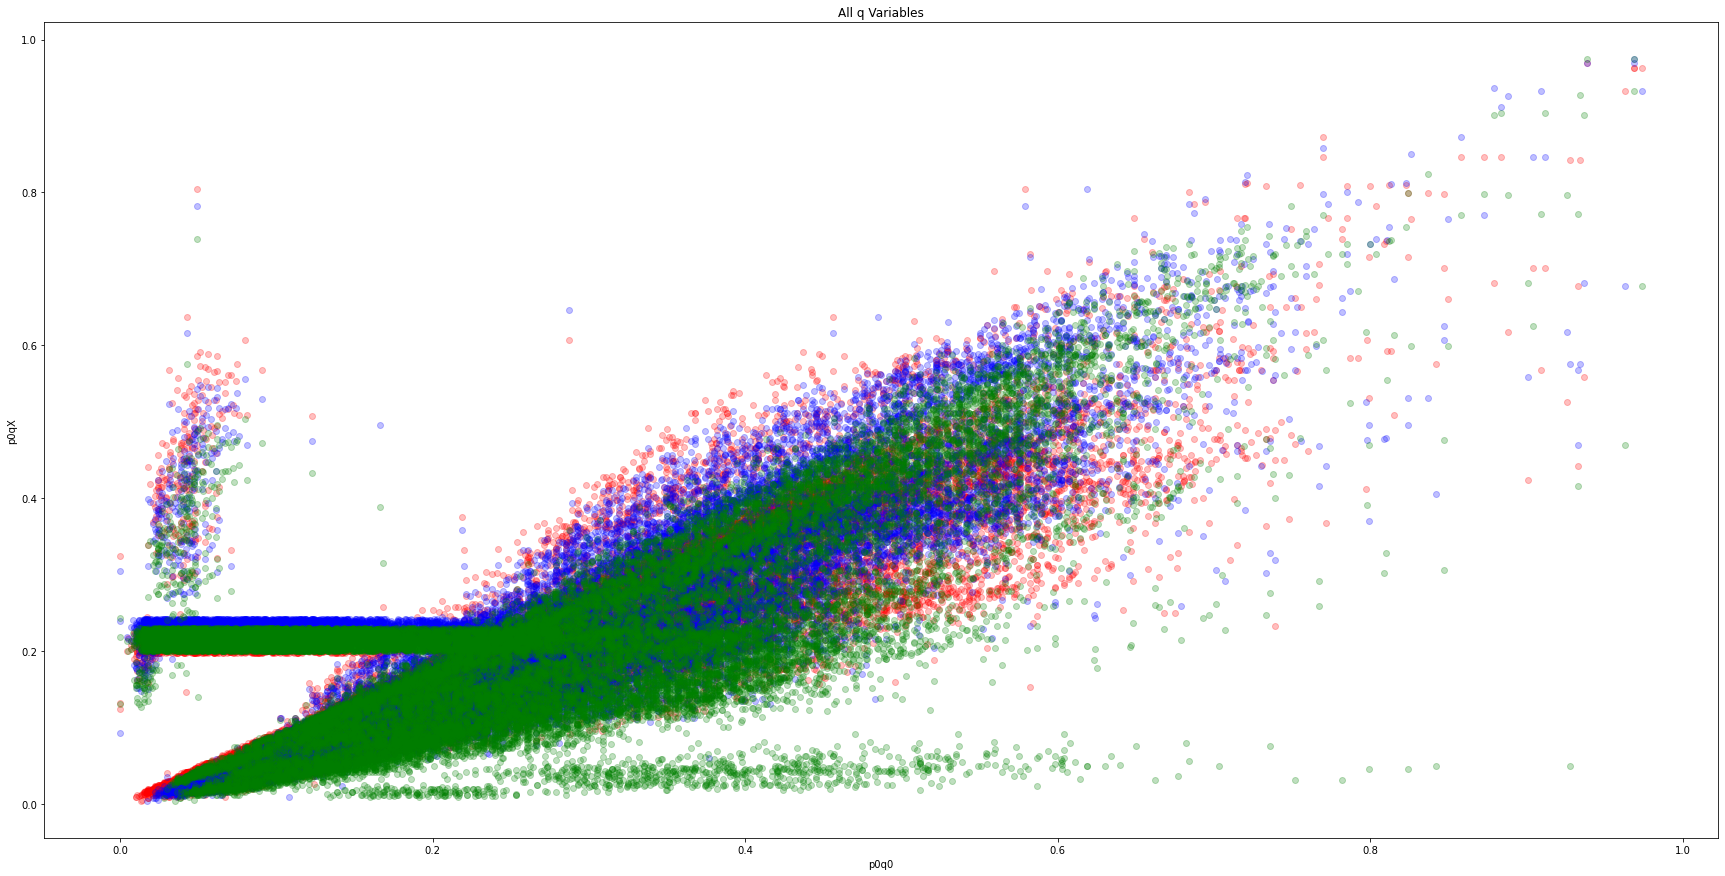

In [17]:
plt.scatter(TrainData["p0q0"], TrainData["p0q1"], c="r", alpha=0.25)
plt.scatter(TrainData["p0q0"], TrainData["p0q2"], c="b", alpha=0.25)
plt.scatter(TrainData["p0q0"], TrainData["p0q3"], c="g", alpha=0.25)
plt.xlabel('p0q0') 
plt.ylabel('p0qX') 
plt.title("All q Variables")

Text(0.5, 1.0, 'All p Variables')

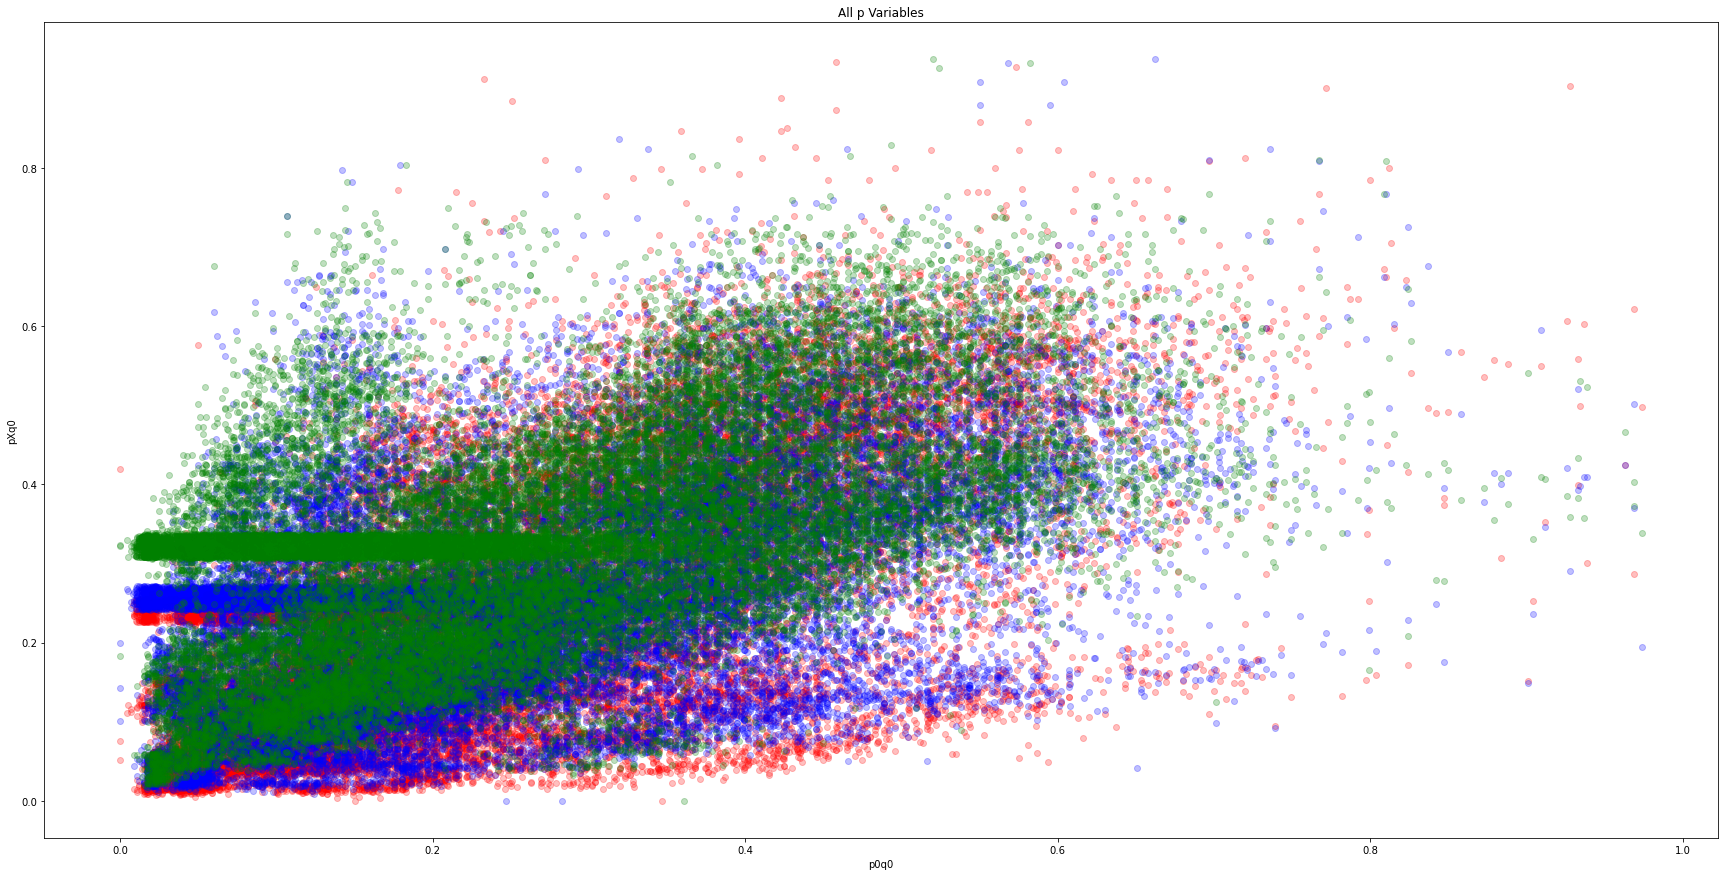

In [18]:
plt.scatter(TrainData["p0q0"], TrainData["p1q0"], c="r", alpha=0.25)
plt.scatter(TrainData["p0q0"], TrainData["p2q0"], c="b", alpha=0.25)
plt.scatter(TrainData["p0q0"], TrainData["p3q0"], c="g", alpha=0.25)
plt.xlabel('p0q0') 
plt.ylabel('pXq0') 
plt.title("All p Variables")

# Cursory Models

## Adding Dummy Variables

Now that our data analysis is complete, we can replace line, train, and station with dummy variables

In [19]:
def addDummies(smart_df):
    for i in range(smart_df["line"].min(),smart_df["line"].max() + 1):
        smart_df["line" + str(i)] = smart_df["line"] == i
        smart_df["line" + str(i)] = smart_df["line" + str(i)].astype(int)

    for i in range(smart_df["train"].min(),smart_df["train"].max() + 1):
        smart_df["train " + str(i)] = smart_df["train"] == i
        smart_df["train " + str(i)] = smart_df["train " + str(i)].astype(int)

    for i in smart_df["station"].unique():
        smart_df[str(i)] = smart_df["station"] == i
        smart_df[str(i)] = smart_df[str(i)].astype(int)
    
    smart_df = smart_df.drop('line', axis=1)
    smart_df = smart_df.drop('train', axis=1)
    smart_df = smart_df.drop('station', axis=1)
    smart_df = smart_df.drop('weekday', axis=1)
    smart_df = smart_df.drop('month', axis=1)

    return smart_df

In [20]:
TrainData = addDummies(TrainData)
TrainData

,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0,line0,line1,line2,...,AA,AC,AG,AH,AR,AU,BA,BI,BJ,AY
0,0.246914,0.260630,0.322580,0.201,0.138,0.091000,0.216,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.240698,0.270717,0.319842,0.204,0.152,0.106000,0.216,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.237548,0.265235,0.318250,0.213,0.153,0.111000,0.227,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.226559,0.241835,0.310470,0.213,0.152,0.108000,0.229,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.236158,0.270773,0.325069,0.210,0.147,0.096000,0.225,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,0.152000,0.188600,0.157000,0.080,0.100,0.201415,0.111,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31115,0.153000,0.180400,0.191000,0.089,0.121,0.217145,0.143,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31116,0.166000,0.149000,0.168000,0.099,0.129,0.221044,0.139,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31117,0.182000,0.193000,0.162000,0.074,0.101,0.225734,0.117,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Linear Regression

Our first attempts to create models involved various regression models. Regression models analyze and predict the values of variables (in this case p0q0) based on the values of other variables. Though we attempted to use five different regression models, we decided to use Linear Regression as our "baseline" due to its relatively high accuracy and simplicity.

In [21]:
def build_model(drop_columns):
    model = TrainData.copy()
    model = model.drop(columns=drop_columns, axis= 1)
    return model

In [22]:
def regressionModels(model, modelName):
    Xtrain = model.drop(columns=['p0q0'], axis=1)
    Ytrain = model['p0q0']

    x_train, x_test, y_train, y_test = train_test_split(Xtrain, Ytrain, test_size = 0.2, random_state = 42)
    regressionModel = modelName
    regressionModel.fit(x_train,y_train)
        
    y_prediction =  regressionModel.predict(x_test)
    
    score = r2_score(y_test,y_prediction)
    mse = mean_squared_error(y_test, y_prediction)
    mae = mean_absolute_error(y_test, y_prediction)

    print(f'r2 socre is:                {round(score,3)}    ->  %{round(score*100,3)}')
    print(f'Mean Squard Error is:       {round(mse,3)}    ->  %{round(mse*100,3)}')
    print(f'Mean Absolute Error is:     {round(mae,3)}    ->  %{round(mae*100,3)}')

In [23]:
droppedColumns = ['p0q1', 'p0q2', 'p0q3']
model = build_model(droppedColumns)
print("Linear Regression: Only pXq0 - (Different Train, Same Station)")
regressionModels(model, LinearRegression())

Linear Regression: Only pXq0 - (Different Train, Same Station)
r2 socre is:                0.861    ->  %86.079
Mean Squard Error is:       0.003    ->  %0.346
Mean Absolute Error is:     0.042    ->  %4.178


In [24]:
droppedColumns = ['p1q0', 'p2q0', 'p3q0']
model = build_model(droppedColumns)
print("Linear Regression: Only p0qX - (Same Train, Different Station)")
regressionModels(model, LinearRegression())

Linear Regression: Only p0qX - (Same Train, Different Station)
r2 socre is:                0.909    ->  %90.925
Mean Squard Error is:       0.002    ->  %0.226
Mean Absolute Error is:     0.034    ->  %3.441


In [25]:
droppedColumns = []
model = build_model(droppedColumns)
print("Linear Regression: All Values")
regressionModels(model, LinearRegression())

Linear Regression: All Values
r2 socre is:                0.913    ->  %91.335
Mean Squard Error is:       0.002    ->  %0.216
Mean Absolute Error is:     0.034    ->  %3.363


## Support Vector, Lasso, Elastic Net, and Ridge Regessions

These are the four other regression models we decided not to use.

In [26]:
droppedColumns = []
model = build_model(droppedColumns)
print("Support Vector Regression: All Values")
regressionModels(model, SVR())

Support Vector Regression: All Values
r2 socre is:                0.873    ->  %87.311
Mean Squard Error is:       0.003    ->  %0.316
Mean Absolute Error is:     0.049    ->  %4.861


In [27]:
droppedColumns = []
model = build_model(droppedColumns)
print("Lasso Regression: All Values")
regressionModels(model, Lasso())

Lasso Regression: All Values
r2 socre is:                -0.0    ->  %-0.036
Mean Squard Error is:       0.025    ->  %2.488
Mean Absolute Error is:     0.13    ->  %12.994


In [28]:
droppedColumns = []
model = build_model(droppedColumns)
print("Elastic Net Regression: All Values")
regressionModels(model, ElasticNet())

Elastic Net Regression: All Values
r2 socre is:                -0.0    ->  %-0.036
Mean Squard Error is:       0.025    ->  %2.488
Mean Absolute Error is:     0.13    ->  %12.994


In [29]:
droppedColumns = []
model = build_model(droppedColumns)
print("Ridge Regression: All Values")
regressionModels(model, Ridge())

Ridge Regression: All Values
r2 socre is:                0.914    ->  %91.373
Mean Squard Error is:       0.002    ->  %0.215
Mean Absolute Error is:     0.033    ->  %3.346


## XGBoost

XGBoost is a simple but effective decision tree model used for predictive modeling. Compared to regression models, XGBoost gives a better Mean Absolute Error score. However, we decided not to use XGBoost due to the model having an overfitting problem. While the model is able to accurately predict training data, it struggles when predicting unseen data.

In [30]:
# Initializes and returns xgboost model with provided hyperparameters
def xgboost_model(x_train, y_train, n_estimators=1000, max_depth=5,eta=.3):
    # n_estimates = number of trees to make prediction. Start small and increase until no improvement
    # max_depth = depth of the tree limiting the n_estimates level
    # eta = learning rate
    xgb_model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=eta, objective='reg:squarederror')
    xgb_model.fit(x_train,y_train)
    return xgb_model

# Given the model, x_test, y_test. Predict and measure using r2, mse, mae
def xgboost_prediction(xgb_model,x_test,y_test):
    y_prediction = xgb_model.predict(x_test)

    score = r2_score(y_test,y_prediction)
    mse = mean_squared_error(y_test, y_prediction)
    mae = mean_absolute_error(y_test,y_prediction)

    print(f'r2 score is:                {round(score,4)}    ->  %{round(score*100,4)}')
    print(f'Mean Square Error is:       {round(mse,4)}    ->  %{round(mse*100,4)}')
    print(f'Mean Absolute Error is:     {round(mae,4)}    ->  %{round(mae*100,4)}')

# Given the model and x_test. Return y_predictions dataframe
def xgboost_submission(xgb_model,x_test):
    y_prediction = xgb_model.predict(x_test)
    return y_prediction

# Plots the models feature importance
def xgboost_plot(model,Xtrain):
    shap_values = shap.TreeExplainer(model).shap_values(Xtrain)
    shap.summary_plot(shap_values,Xtrain)

r2 score is:                0.9854    ->  %98.5373
Mean Square Error is:       0.0004    ->  %0.0364
Mean Absolute Error is:     0.0112    ->  %1.1239


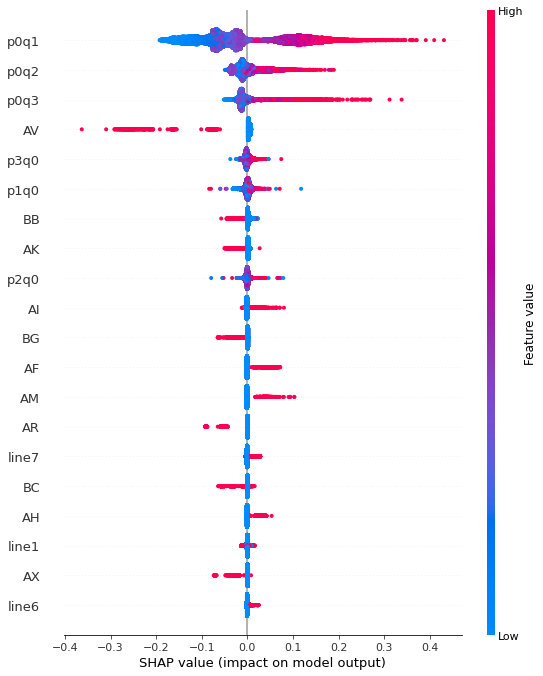

In [31]:
model = TrainData.copy()
columns = ['p0q0']
Xtrain = model.drop(columns=columns, axis=1)
Ytrain = model['p0q0']

x_train, x_test, y_train, y_test = train_test_split(Xtrain, Ytrain, test_size = 0.2, random_state = 42)

xgb_model = xgboost_model(x_train,y_train)
xgboost_prediction(xgb_model,x_test,y_test)
xgboost_plot(xgb_model,Xtrain)

r2 score is:                0.9865    ->  %98.6455
Mean Square Error is:       0.0003    ->  %0.0337
Mean Absolute Error is:     0.0106    ->  %1.059


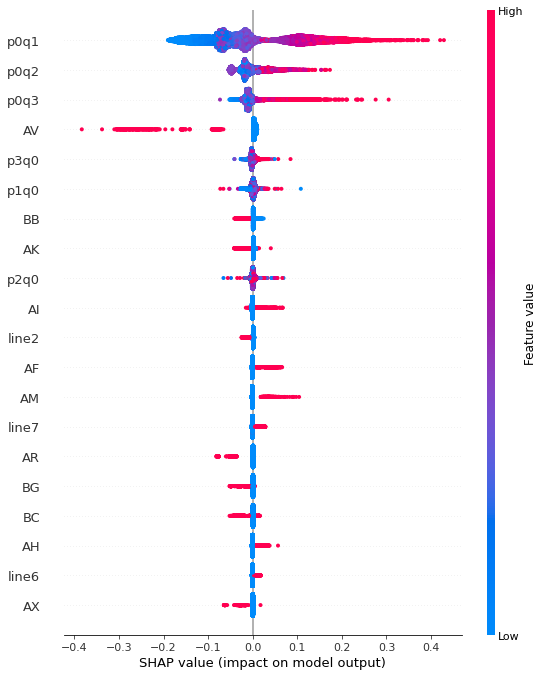

In [32]:
xgb_model = xgboost_model(x_train,y_train,n_estimators=5000,max_depth=6,eta=.05)
xgboost_prediction(xgb_model,x_test,y_test)
xgboost_plot(xgb_model,Xtrain)

# Final Model (Deep Neural Network) 

Our Deep Neural Network provided the lowest Mean Absolute Error as well as the best score on the competition website out of any of the models we used. As of 4/18/23, we are 12th place (0.0100) out of 48 entries with a benchmark of 0.0131 Mean Absolute Error. 1st place has a MAE scor of 0.0039.

In [33]:
def train_dnn(model, epochs):
    Xtrain = model.drop(columns=['p0q0'], axis=1)
    Ytrain = model['p0q0']
    
    x_train, x_test, y_train, y_test = train_test_split(Xtrain, Ytrain, test_size = 0.2, random_state = 42)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    model=keras.models.Sequential([
        keras.layers.Dense(512, input_dim = x_train.shape[1], activation='relu'),  
        keras.layers.Dense(512, input_dim = x_train.shape[1], activation='relu'),  
        keras.layers.Dense(units=256,activation='relu'),  
        keras.layers.Dense(units=256,activation='relu'),    
        keras.layers.Dense(units=128,activation='relu'),
        keras.layers.Dense(units=1, activation="linear"),
    ],name="Initial_model",)
    
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    
    checkpoint_name = 'Weights\checkpoint.hdf5' 
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_weights_only = True, save_best_only = True, mode ='auto')
    callbacks_list = [checkpoint]

    history = model.fit(x_train, y_train,
                    epochs=epochs, batch_size=1024,
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks_list, 
                    verbose=1)
    
    model.load_weights('Weights\checkpoint.hdf5')
        
    y_prediction = model.predict(x_test)  
    
    score = r2_score(y_test,y_prediction)
    mse = mean_squared_error(y_test, y_prediction)
    mae = mean_absolute_error(y_test, y_prediction)

    print(f'r2 socre is:             {round(score,5)}  ->  %{round(score*100,5)}')
    print(f'Mean Squard Error is:    {round(mse,5)}  ->  %{round(mse*100,5)}')
    print(f'Mean Absolute Error is:  {round(mae,5)}  ->  %{round(mae*100,5)}')

In [34]:
droppedColumns = []
model = build_model(droppedColumns)
train_dnn(model, 250)

Epoch 1/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0827
Epoch 1: val_loss improved from inf to 0.02762, saving model to Weights\checkpoint.hdf5
25/25 [==============================] - 2s 47ms/step - loss: 0.0798 - val_loss: 0.0276
Epoch 2/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0211
Epoch 2: val_loss improved from 0.02762 to 0.01900, saving model to Weights\checkpoint.hdf5
25/25 [==============================] - 1s 34ms/step - loss: 0.0210 - val_loss: 0.0190
Epoch 3/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0173
Epoch 3: val_loss improved from 0.01900 to 0.01697, saving model to Weights\checkpoint.hdf5
25/25 [==============================] - 1s 34ms/step - loss: 0.0173 - val_loss: 0.0170
Epoch 4/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0160
Epoch 4: val_loss improved from 0.01697 to 0.01512, saving model to Weights\checkpoint.hdf5
25/25 [==============================] - 1s 35ms/step - loss: 0.0160

24/25 [===========================>..] - ETA: 0s - loss: 0.0117
Epoch 37: val_loss did not improve from 0.01181
25/25 [==============================] - 1s 31ms/step - loss: 0.0117 - val_loss: 0.0120
Epoch 38/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0116
Epoch 38: val_loss did not improve from 0.01181
25/25 [==============================] - 1s 31ms/step - loss: 0.0116 - val_loss: 0.0127
Epoch 39/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0119
Epoch 39: val_loss did not improve from 0.01181
25/25 [==============================] - 1s 30ms/step - loss: 0.0119 - val_loss: 0.0123
Epoch 40/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0117
Epoch 40: val_loss improved from 0.01181 to 0.01174, saving model to Weights\checkpoint.hdf5
25/25 [==============================] - 1s 32ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 41/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0117
Epoch 41: val_loss did not improve from

24/25 [===========================>..] - ETA: 0s - loss: 0.0108
Epoch 74: val_loss did not improve from 0.01104
25/25 [==============================] - 1s 30ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 75/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0105
Epoch 75: val_loss did not improve from 0.01104
25/25 [==============================] - 1s 31ms/step - loss: 0.0105 - val_loss: 0.0112
Epoch 76/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0104
Epoch 76: val_loss did not improve from 0.01104
25/25 [==============================] - 1s 31ms/step - loss: 0.0104 - val_loss: 0.0114
Epoch 77/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0105
Epoch 77: val_loss did not improve from 0.01104
25/25 [==============================] - 1s 30ms/step - loss: 0.0105 - val_loss: 0.0124
Epoch 78/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0107
Epoch 78: val_loss did not improve from 0.01104
25/25 [=============================

25/25 [==============================] - 1s 31ms/step - loss: 0.0100 - val_loss: 0.0110
Epoch 112/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0102
Epoch 112: val_loss did not improve from 0.01073
25/25 [==============================] - 1s 30ms/step - loss: 0.0103 - val_loss: 0.0116
Epoch 113/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0101
Epoch 113: val_loss did not improve from 0.01073
25/25 [==============================] - 1s 31ms/step - loss: 0.0101 - val_loss: 0.0109
Epoch 114/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0098
Epoch 114: val_loss did not improve from 0.01073
25/25 [==============================] - 1s 31ms/step - loss: 0.0098 - val_loss: 0.0121
Epoch 115/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0104
Epoch 115: val_loss did not improve from 0.01073
25/25 [==============================] - 1s 31ms/step - loss: 0.0103 - val_loss: 0.0108
Epoch 116/250
23/25 [==========================>...]

Epoch 149/250
25/25 [==============================] - ETA: 0s - loss: 0.0100
Epoch 149: val_loss did not improve from 0.01029
25/25 [==============================] - 1s 30ms/step - loss: 0.0100 - val_loss: 0.0113
Epoch 150/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0097
Epoch 150: val_loss did not improve from 0.01029
25/25 [==============================] - 1s 30ms/step - loss: 0.0097 - val_loss: 0.0106
Epoch 151/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0093
Epoch 151: val_loss did not improve from 0.01029
25/25 [==============================] - 1s 30ms/step - loss: 0.0094 - val_loss: 0.0109
Epoch 152/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0094
Epoch 152: val_loss did not improve from 0.01029
25/25 [==============================] - 1s 29ms/step - loss: 0.0095 - val_loss: 0.0110
Epoch 153/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0096
Epoch 153: val_loss did not improve from 0.01029
25/25 [======

Epoch 187/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0092
Epoch 187: val_loss did not improve from 0.00996
25/25 [==============================] - 1s 31ms/step - loss: 0.0092 - val_loss: 0.0109
Epoch 188/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0090
Epoch 188: val_loss did not improve from 0.00996
25/25 [==============================] - 1s 31ms/step - loss: 0.0090 - val_loss: 0.0111
Epoch 189/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0091
Epoch 189: val_loss did not improve from 0.00996
25/25 [==============================] - 1s 30ms/step - loss: 0.0091 - val_loss: 0.0103
Epoch 190/250
25/25 [==============================] - ETA: 0s - loss: 0.0089
Epoch 190: val_loss did not improve from 0.00996
25/25 [==============================] - 1s 29ms/step - loss: 0.0089 - val_loss: 0.0112
Epoch 191/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0092
Epoch 191: val_loss did not improve from 0.00996
25/25 [======

Epoch 225/250
25/25 [==============================] - ETA: 0s - loss: 0.0087
Epoch 225: val_loss did not improve from 0.00991
25/25 [==============================] - 1s 31ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 226/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0087
Epoch 226: val_loss improved from 0.00991 to 0.00991, saving model to Weights\checkpoint.hdf5
25/25 [==============================] - 1s 32ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 227/250
23/25 [==========================>...] - ETA: 0s - loss: 0.0087
Epoch 227: val_loss did not improve from 0.00991
25/25 [==============================] - 1s 33ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 228/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0088
Epoch 228: val_loss did not improve from 0.00991
25/25 [==============================] - 1s 30ms/step - loss: 0.0088 - val_loss: 0.0112
Epoch 229/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0087
Epoch 229: val_lo

# Conclusion